# Анализ физических лиц: построение мультимодальной тематической модели

Описание модели:
- 400к клиентов 
- данные в виде транзакций
- НЕ темпоральная модель (время не учитывается)
- построена по абсолютным суммам транзакций
- построена по номерам карт
- 30 тем
- с модальностями

In [1]:
import sys
sys.path.append('/home/roseaysina/bigartm/python')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import json
import artm
import re
import pickle

In [3]:
import sys
sys.path.insert(0, '../code/')

In [4]:
import tm_experiments as tme
import tm_metrics as tmm
import segmentation as seg

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Загрузка данных

In [6]:
path_mcc = '../data/tr_mcc_codes.csv'
mcc_df = pd.read_csv(path_mcc, sep=';')

mcc_df['mcc_code'] = mcc_df['mcc_code'].astype(str)
print('Number of unique MCC:', mcc_df['mcc_code'].nunique())

mcc_df.head()

Number of unique MCC: 290


,mcc_code,mcc_name,mcc_description,mcc_category
0,742,Ветеринарные услуги,"Профессионалы, с лицензией в основном занимающ...",Контрактные услуги
1,763,Сельско-хозяйственные кооперативные общества,"Ассоциации и кооперативы, предлагающие услуги ...",Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Архитекторы по ландшафту и другие специалисты ...,Контрактные услуги
3,1520,Генеральные подрядчики - жилищное и торговое с...,Генеральные подрядчики в основном занимаются с...,Контрактные услуги
4,1711,"Генеральные подрядчики по вентиляции, теплосна...","Особые строительные (торговые) подрядчики, раб...",Контрактные услуги


In [7]:
mcc2descr = {str(row['mcc_code']): row['mcc_name']
             for index, row in mcc_df.iterrows()}

## Для чего строится модель: клиентов или карт

In [8]:
user_field = 'client_id_way4'
#user_field = 'cardnumber'

# Загрузка батчей и словаря:

In [9]:
batch_vectorizer = artm.BatchVectorizer(target_folder='../data/topic_model_files', 
                                        data_path='../data/data_400k_vw_meta_clients.txt',
                                        data_format='vowpal_wabbit')

In [10]:
dictionary = batch_vectorizer.dictionary
num_topics = 30  # количество тем
num_back = 1  # количество тем общей лексики

In [11]:
thresholds = [0, 0.3, 0.5, 0.7, 0.9]

In [12]:
num_iter = 15

# К уже хорошо обученной тематической модели добавляются модальности: возрастная категория и пол

# 0. Модель PLSA

In [13]:
model0 = artm.ARTM(num_topics=num_topics, class_ids={'@default': 1.0, '@age': 0.5, '@gender': 0.5, '@msd':0.5, '@edu':0.5},
                   dictionary=dictionary, cache_theta=True, reuse_theta=True,
                   theta_columns_naming='title', theta_name = 'theta')
model0.scores.add(artm.PerplexityScore(name='PerplexityScore_meta', dictionary=dictionary, class_ids=['@age', '@gender', '@msd', '@edu']))
model0.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary, class_ids=['@default']))
model0.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore',
                                        topic_names=model0.topic_names[:-num_back], class_id='@default'))

model0.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore',
                                          topic_names=model0.topic_names[:-num_back]))

model0.scores.add(artm.TopTokensScore(name='TopTokensScore', dictionary=dictionary, class_id='@default'))

In [14]:
model0.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_iter)

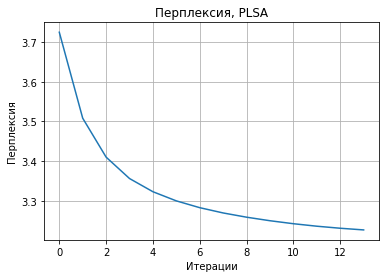

In [15]:
tmm.plot_perplexity(model0, 'PLSA')

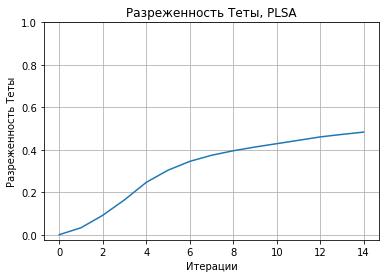

In [16]:
tmm.plot_theta_sparsity(model0, 'PLSA')

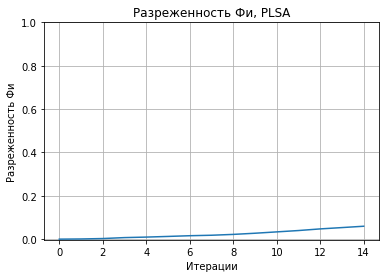

In [17]:
tmm.plot_phi_sparsity(model0, 'PLSA')

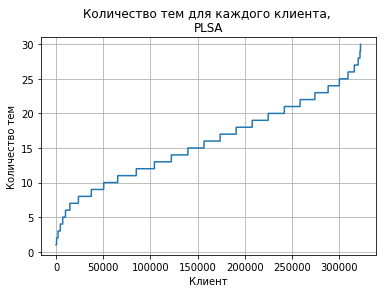

In [18]:
tmm.plot_people_score(model0, 0, '\nPLSA')

[26 13 21 27 20 11 28 10  6  1 18  4 24 23  8 25 14  5 17  0  3  7 15 12
 29  9  2 22 16 19]


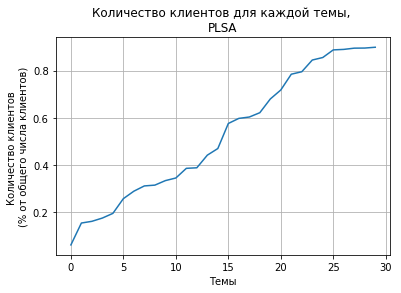

In [19]:
tmm.plot_topics_score(model0, 0, '\nPLSA')

In [20]:
tmm.print_top_tokens(model0, mcc2descr, thresholds, 
                     'PLSA', 
                     '../data/VCR/plsa_no_grp_mlt.txt',
                     modalities=['@msd', '@edu', '@age', '@gender'])

In [21]:
model0.get_theta().shape

(30, 322974)

In [22]:
model0.dump_artm_model('../data/VCR/plsa_no_grp_mlt')

# 1. Разреживание Фи для предметных тем

In [23]:
best_tau = -3000.
model1 = model0.clone()
model1.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhiRegularizer',
                                                        class_ids=['@default'],
                                                        tau=best_tau,
                                                        topic_names=model1.topic_names[:-num_back]))
model1.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

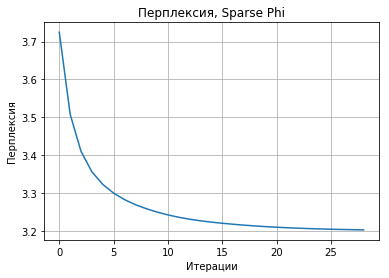

In [24]:
tmm.plot_perplexity(model1, 'Sparse Phi')

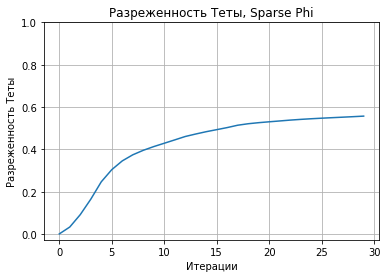

In [25]:
tmm.plot_theta_sparsity(model1, 'Sparse Phi')

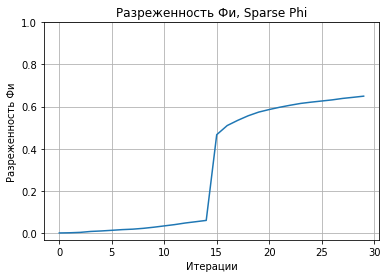

In [26]:
tmm.plot_phi_sparsity(model1, 'Sparse Phi')

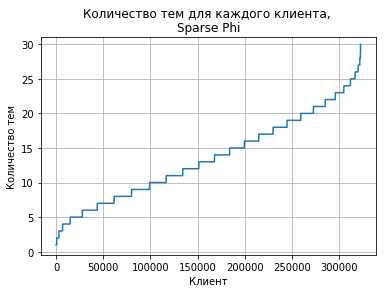

In [27]:
tmm.plot_people_score(model1, 0, '\nSparse Phi')

[26 13 21 27 20 11 10  1 28 12  6 17 18  4 24 23  7  8 25 14  5  0  3 29
  9 19 15  2 16 22]


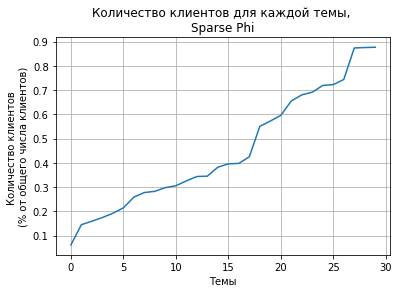

In [28]:
tmm.plot_topics_score(model1, 0, '\nSparse Phi')

In [29]:
tmm.print_top_tokens(model1, mcc2descr, thresholds, 'Sparse Phi', 
                     '../data/topic_model_files/spars_phi.txt', 
                     modalities=['@msd', '@edu', '@age', '@gender'])

# 2. Сглаживание Фи для тем общей лексики

Подбор коэффициентов:

In [30]:
best_tau = 100
model2 = model1.clone()
model2.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhiRegularizer',
                                                        class_ids=['@default'],
                                                        tau=best_tau,
                                                        topic_names=model2.topic_names[-num_back:]))
model2.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

In [31]:
tmm.print_top_tokens(model2, mcc2descr, thresholds, 
                     'Smooth Phi', 
                     '../data/topic_model_files/smooth_phi.txt', 
                     modalities=['@msd', '@edu', '@age', '@gender'])

In [32]:
best_tau = -500
model3 = model2.clone()
model3.regularizers.add(artm.DecorrelatorPhiRegularizer(name='Dec',
                                                        class_ids=['@default'],
                                                        tau=best_tau))
model3.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

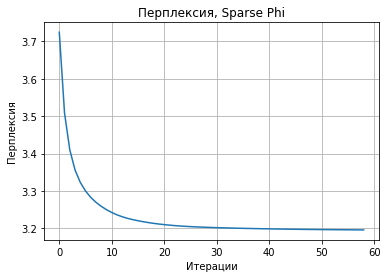

In [33]:
tmm.plot_perplexity(model3, 'Sparse Phi')

# 3. Разреживание Теты для предметных тем

In [34]:
best_tau = -400
model4 = model3.clone()
model4.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseThetaRegularizer',
                                                        tau=best_tau,
                                                        topic_names=model3.topic_names[:-num_back]))
model4.fit_offline(batch_vectorizer=batch_vectorizer,
                   num_collection_passes=num_iter)

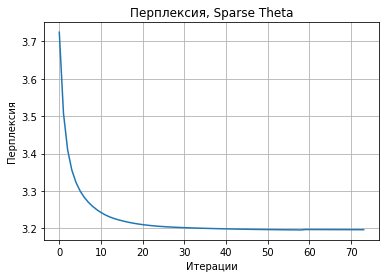

In [41]:
tmm.plot_perplexity(model4, 'Sparse Theta')

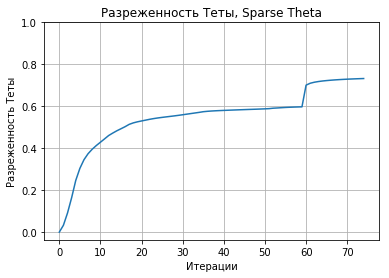

In [42]:
tmm.plot_theta_sparsity(model4, 'Sparse Theta')

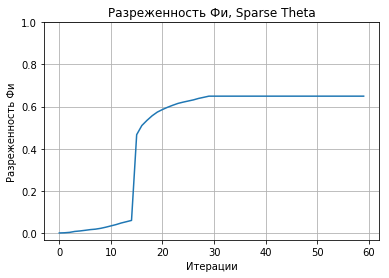

In [43]:
tmm.plot_phi_sparsity(model3, 'Sparse Theta')

[26 13 21 27 20 11  7 10  1 12 28  6 17  4 18 24 23 19  8 25 14  5  9  0
 22  3 29 15 16  2]


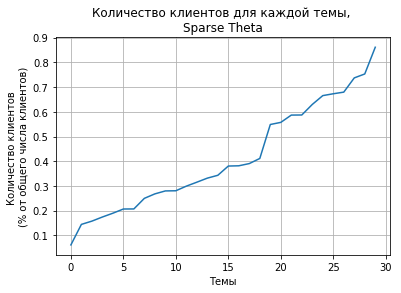

In [44]:
tmm.plot_topics_score(model3, 0, '\nSparse Theta')

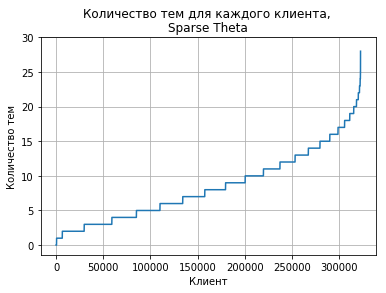

In [45]:
tmm.plot_people_score(model4, 0, '\nSparse Theta')

In [46]:
tmm.print_top_tokens(model4, mcc2descr, thresholds, 
                     'Spase Theta', 
                     '../data/VCR/reg_plsa_nogrp_mlt.txt',
                     modalities=['@msd', '@edu', '@age', '@gender'])

/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


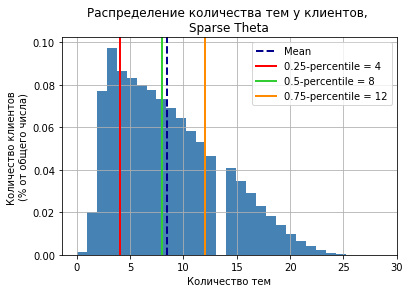

In [47]:
tmm.plot_hist_people_score(model4, 0, '\nSparse Theta')

/home/phillnik/miniconda3/envs/tf_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


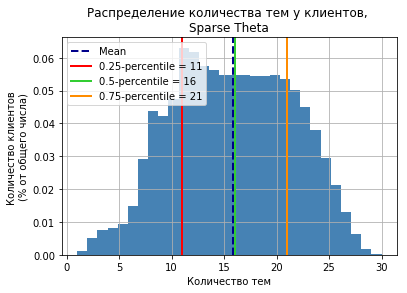

In [48]:
tmm.plot_hist_people_score(model0, 0, '\nSparse Theta')

## Сохранение модели:

In [50]:
path_save = '../data/VCR/reg_plsa_nogrp_mlt'
model4.dump_artm_model(path_save)

# Сравнение всех моделей

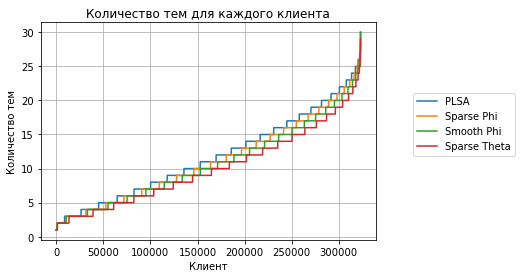

[26 13 21 27 20  7 11 10  1 12 28  6  3 17  4 18 23 24 19  8 22 14 25  9  5
  0 29 16 15  2]
[26 13 21 27 20  7 11 10  3  1 12 28  6 17  4 18 23  0 19 24  8 22 14 25  9
  5 29 16 15  2]
[26 13 21 27 20 12  7 11 10  3  0  1 28  6 17  4 18 23 19 24  8 22 14  5 25
  9 29 16 15  2]
[26 13 21 27 12 20  7 11  0  3 10  1 28  6 17  4 18 14 23 19 24 22  5  8  9
 25  2 29 16 15]


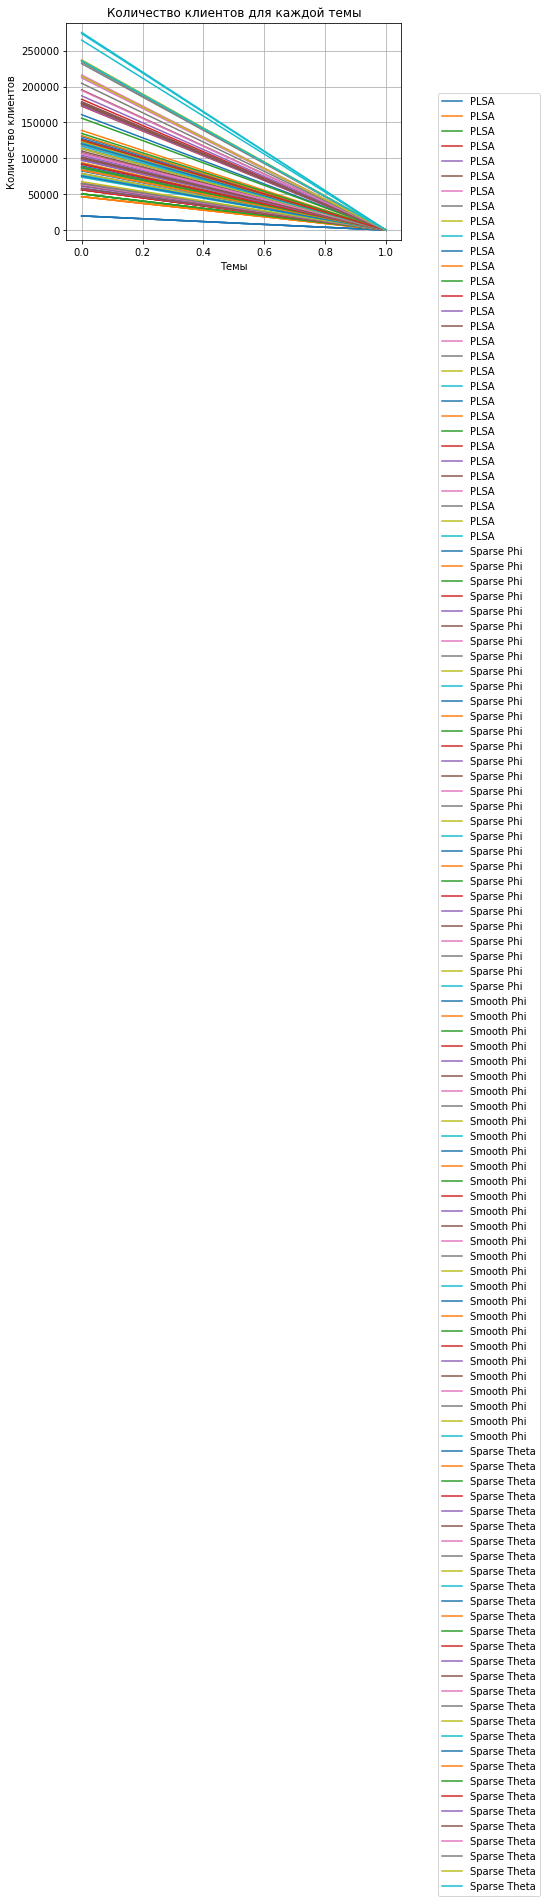

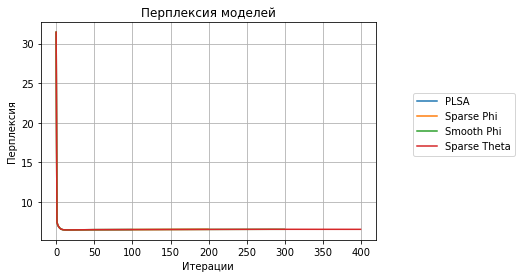

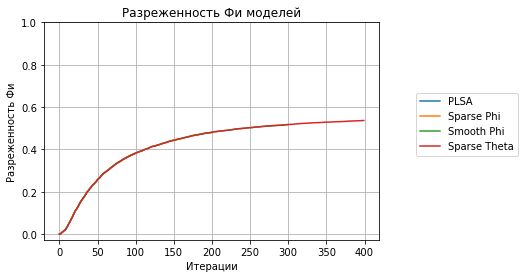

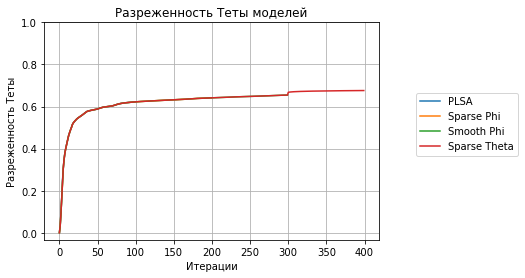

In [44]:
models = [model0, model1, model2, model3]
labels = ['PLSA', 'Sparse Phi', 'Smooth Phi', 'Sparse Theta']

tmm.plot_people_comparison(models, labels)
tmm.plot_topics_comparison(models, labels)
tmm.plot_perplexity_comparison(models, labels)
tmm.plot_phi_sparsity_comparison(models, labels)
tmm.plot_theta_sparsity_comparison(models, labels)